#Conv MNIST AE

## Installation and imports

In [1]:
!mkdir figures
!mkdir scripts
%cd /content/scripts
# !wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/pyprobml_utils.py
# !wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/lvm_plots_utils.py
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/ae-mnist-conv-latent-dim-2.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/ae-mnist-conv-latent-dim-20.ckpt
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/ae_mnist_conv.py

/content/scripts


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

try:
    import torch
except ModuleNotFoundError:
    %pip install -qq torch
    import torch
import torch.nn as nn

try:
    from torchvision.datasets import MNIST
except ModuleNotFoundError:
    %pip install -qq torchvision
    from torchvision.datasets import MNIST
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

try:
    from pytorch_lightning import LightningModule, Trainer
except ModuleNotFoundError:
    %pip install -qq pytorch_lightning
    from pytorch_lightning import LightningModule, Trainer
try:
    from einops import rearrange
except ModuleNotFoundError:
    %pip install -qq einops
    from einops import rearrange
import seaborn as sns

try:
    from probml_utils.lvm_plots_utils import (
        get_random_samples,
        get_grid_samples,
        plot_scatter_plot,
        get_imrange,
        plot_grid_plot,
    )
except:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils.lvm_plots_utils import (
        get_random_samples,
        get_grid_samples,
        plot_scatter_plot,
        get_imrange,
        plot_grid_plot,
    )


from torchvision.utils import make_grid
from pytorch_lightning.utilities.seed import seed_everything
from ae_mnist_conv import ConvAE

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
mnist_full = MNIST(".", download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))

dm = DataLoader(mnist_full, batch_size=512, shuffle=True)

vis_data = DataLoader(mnist_full, batch_size=5000)
batch = next(iter(vis_data))


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Basic Conv VAE Module

In [6]:
ae = ConvAE((1, 28, 28), encoder_conv_filters=[28, 64, 64], decoder_conv_t_filters=[64, 28, 1], latent_dim=20)
ae.load_state_dict(torch.load("ae-mnist-conv-latent-dim-20.ckpt"))
ae.to(device)

ConvAE(
  (vae): ConvAEModule(
    (enc_convs): ModuleList(
      (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(28, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01)
    )
    (mu_linear): Sequential(
      (0): Linear(in_features=1024, out_features=20, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.2, inplace=False)
    )
    (log_var_linear): Sequential(
      (0): Linear(in_features=1024, out_features=20, bias=True)
      (1): LeakyReLU(nega

In [7]:
ae2 = ConvAE((1, 28, 28), encoder_conv_filters=[28, 64, 64], decoder_conv_t_filters=[64, 28, 1], latent_dim=2)
ae2.load_state_dict(torch.load("ae-mnist-conv-latent-dim-2.ckpt"))
ae2.to(device)

ConvAE(
  (vae): ConvAEModule(
    (enc_convs): ModuleList(
      (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(28, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.01)
    )
    (mu_linear): Linear(in_features=1024, out_features=2, bias=True)
    (log_var_linear): Linear(in_features=1024, out_features=2, bias=True)
    (decoder_linear): Linear(in_features=2, out_features=1024, bias=True)
    (dec_t_convs): ModuleList(
      (0): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
      (1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): LeakyReLU(negative_slope=0.01)
      (3): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
      (4): ConvTranspose2d(64, 28, kernel_size=(3, 3), stride=(1, 1), paddin

## Reconstruction

### ConvAE with latent dim 20

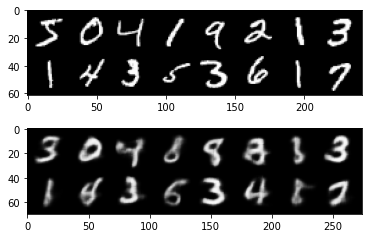

In [8]:
imgs, _ = batch
imgs = imgs[:16]

fig, axs = plt.subplots(2, 1)
axs[0].imshow(rearrange(make_grid(imgs), "c h w -> h w c"))
imgs = imgs.to(device=device)
axs[1].imshow(rearrange(make_grid(ae.vae(imgs)[0].cpu()), "c h w -> h w c"))
plt.savefig("../figures/ae_mnist_conv_20d_rec.pdf")
plt.show()

### ConvAE with latent dim 2

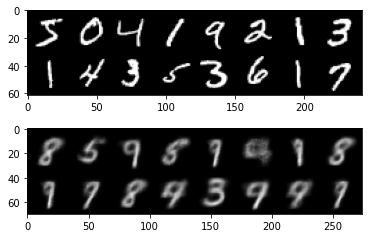

In [9]:
imgs, _ = batch
imgs = imgs[:16]

fig, axs = plt.subplots(2, 1)
axs[0].imshow(rearrange(make_grid(imgs), "c h w -> h w c"))
imgs = imgs.to(device=device)
axs[1].imshow(rearrange(make_grid(ae2.vae(imgs)[0].cpu()), "c h w -> h w c"))
plt.savefig("../figures/ae_mnist_conv_2d_rec.pdf")
plt.show()

## Sampling

### Random samples from truncated normal distribution 

We sample $z \sim TN(0,1)$ form a truncated normal distribution with a threshold = 5


#### ConvAE with latent dim 20

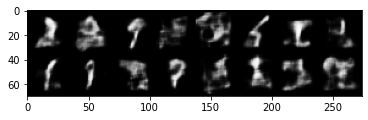

In [19]:
def decoder(z):
    return ae.vae.decode(z)


plt.figure()
imgs = get_random_samples(decoder, truncation_threshold=5, num_images_per_row=8, num_images=16)
plt.imshow(imgs)
plt.savefig("../figures/ae_mnist_conv_20d_samples.pdf")

#### ConvAE with latent dim 2

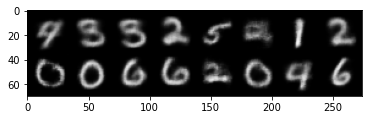

In [20]:
def decoder(z):
    return ae2.vae.decode(z)


plt.figure()
imgs = get_random_samples(decoder, truncation_threshold=5, num_images_per_row=8, num_images=16)
plt.imshow(imgs)
plt.savefig("../figures/ae_mnist_conv_2d_samples.pdf")

### Grid Sampling

#### ConvAE with latent dim 20

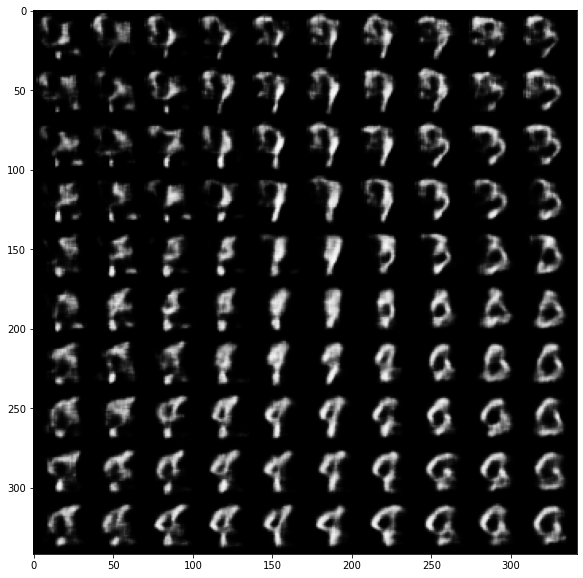

In [ ]:
def decoder(z):
    return ae.vae.decode(z)[0]


plt.figure(figsize=(10, 10))
plt.imshow(rearrange(make_grid(get_grid_samples(decoder, 20), 10), " c h w -> h w c").cpu())

#### ConvAE with latent dim 2

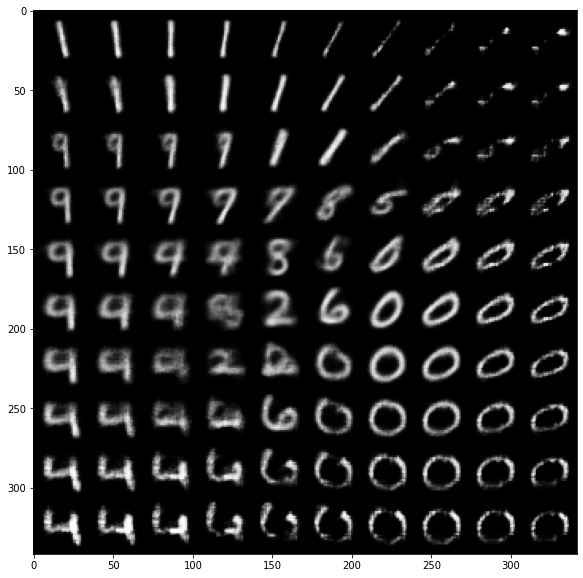

In [ ]:
def decoder(z):
    return ae2.vae.decode(z)[0]


plt.figure(figsize=(10, 10))
plt.imshow(rearrange(make_grid(get_grid_samples(decoder, 20), 10), " c h w -> h w c").cpu())

## 2D Color embedding of latent space

### ConvVAE with latent dim 20

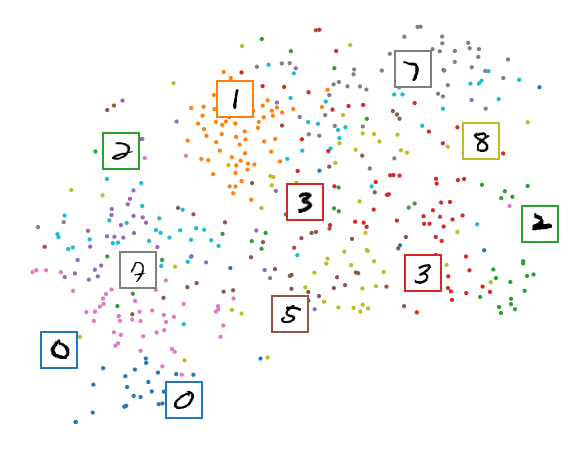

In [ ]:
def encoder(img):
    return ae.vae.encode(img)[0]


def decoder(z):
    z = z.to(device)
    return rearrange(ae.vae.decode(z), "b c h w -> b (c h) w")


plot_scatter_plot(batch, encoder)

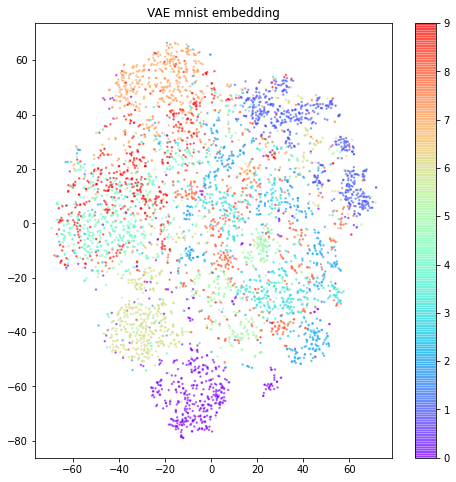

In [13]:
def encoder(img):
    return ae.vae.encode(img)[0]


def decoder(z):
    z = z.to(device)
    return rearrange(ae.vae.decode(z), "b c h w -> b (c h) w")


fig = plot_grid_plot(batch, encoder)
fig.savefig("../figures/ae_mnist_conv_20d_embed.pdf")
plt.show()

### ConvAE with latent dim 2

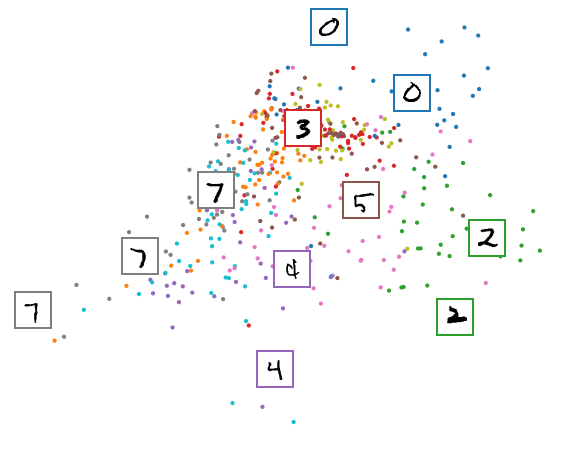

In [ ]:
def encoder(img):
    return ae2.vae.encode(img)[0].cpu().detach().numpy()


def decoder(z):
    z = z.to(device)
    return rearrange(ae2.vae.decode(z), "b c h w -> b (c h) w")


plot_scatter_plot(batch, encoder)

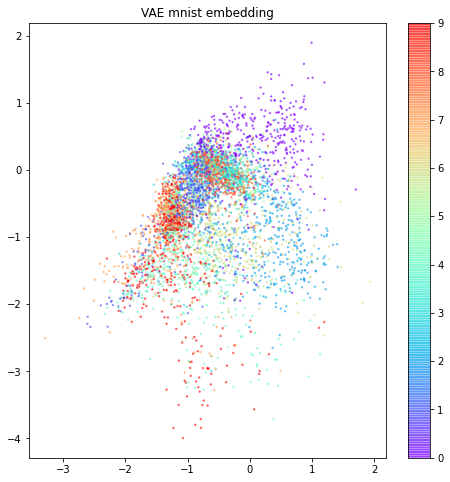

In [14]:
def encoder(img):
    return ae2.vae.encode(img)[0].cpu().detach().numpy()


def decoder(z):
    z = z.to(device)
    return rearrange(ae2.vae.decode(z), "b c h w -> b (c h) w")


fig = plot_grid_plot(batch, encoder)
fig.savefig("../figures/ae_mnist_conv_2d_embed.pdf")
plt.show()

## Interpolation

### Spherical Interpolation

#### ConvAE with latent dim 20

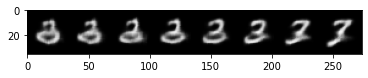

In [15]:
def decoder(z):
    z = z.to(device)
    return rearrange(ae.vae.decode(z), "b c h w -> b (c h) w")


def encoder(img):
    return ae.vae.encode(img)[0].cpu().detach()


imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
# end, start = z_imgs[1], z_imgs[3]
end, start = z_imgs[0], z_imgs[5]

plt.figure()
arr = get_imrange(decoder, start, end, interpolation="spherical")
plt.imshow(arr)

#### ConAE with latent dim 2

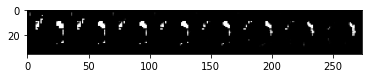

In [16]:
def decoder(z):
    z = z.to(device)
    return rearrange(ae2.vae.decode(z), "b c h w -> b (c h) w")


def decoder(z):
    z = z.to(device)
    return rearrange(ae2.vae.decode(z), "b c h w -> b (c h) w")


imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
# end, start = z_imgs[1], z_imgs[3]
end, start = z_imgs[0], z_imgs[5]

plt.figure()
arr = get_imrange(decoder, start, end, interpolation="spherical")
plt.imshow(arr)

### Linear Interpolation

#### ConvAE with latent dim 20

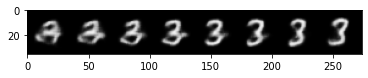

In [17]:
def decoder(z):
    z = z.to(device)
    return rearrange(ae.vae.decode(z), "b c h w -> b (c h) w")


def decoder(z):
    z = z.to(device)
    return rearrange(ae.vae.decode(z), "b c h w -> b (c h) w")


imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
# end, start = z_imgs[1], z_imgs[3]
end, start = z_imgs[0], z_imgs[5]

plt.figure()
arr = get_imrange(decoder, start, end, interpolation="linear")
plt.imshow(arr)
plt.savefig("../figures/ae_mnist_conv_20d_linear.pdf")

#### ConvAE with latent dim 2

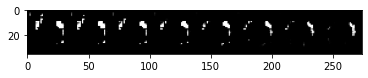

In [18]:
def decoder(z):
    z = z.to(device)
    return rearrange(ae2.vae.decode(z), "b c h w -> b (c h) w")


def decoder(z):
    z = z.to(device)
    return rearrange(ae2.vae.decode(z), "b c h w -> b (c h) w")


imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
# end, start = z_imgs[1], z_imgs[3]
end, start = z_imgs[0], z_imgs[5]

plt.figure()
arr = get_imrange(decoder, start, end, interpolation="linear")
plt.imshow(arr)
plt.savefig("../figures/ae_mnist_conv_2d_linear.pdf")